# **Music Recommendation System**
Dataset yang akan digunakan adalah data Million Song Dataset + Spotify + Last.fm yang di dapatkan dari Kaggle https://www.kaggle.com/datasets/undefinenull/million-song-dataset-spotify-lastfm. Tujuan dari proyek ini yaitu untuk membuat sistem rekomendasi lagu yang dapat memberikan rekomendasi kepada user setelah user mendengar sebuah lagu. Dataset terdiri dari 2 file yaitu Music Info.csv dan User Listening History.csv.

# **1. Import Library**

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.sparse as sp
import joblib

from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# **2. Memuat and Extract Dataset**
Memuat dataset yang telah di download dari kaggle dan disimpan di local

In [2]:
zip_path = "archive.zip"
extract_dir = 'C:/Users/muham/Downloads/system_recommendation/dataset'

# Buat folder tujuan
os.makedirs(extract_dir, exist_ok=True)

# Ekstrak
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Berhasil di-ekstrak ke: {extract_dir}")

music_df = pd.read_csv(extract_dir + '/Music Info.csv')
user_listening_history_df = pd.read_csv(extract_dir + '/User Listening History.csv')

Berhasil di-ekstrak ke: C:/Users/muham/Downloads/system_recommendation/dataset


In [3]:
music_df.head()

track_id             name           artist  \
0  TRIOREW128F424EAF0   Mr. Brightside      The Killers   
1  TRRIVDJ128F429B0E8       Wonderwall            Oasis   
2  TROUVHL128F426C441  Come as You Are          Nirvana   
3  TRUEIND128F93038C4      Take Me Out  Franz Ferdinand   
4  TRLNZBD128F935E4D8            Creep        Radiohead   

                                 spotify_preview_url              spotify_id  \
0  https://p.scdn.co/mp3-preview/4d26180e6961fd46...  09ZQ5TmUG8TSL56n0knqrj   
1  https://p.scdn.co/mp3-preview/d012e536916c927b...  06UfBBDISthj1ZJAtX4xjj   
2  https://p.scdn.co/mp3-preview/a1c11bb1cb231031...  0keNu0t0tqsWtExGM3nT1D   
3  https://p.scdn.co/mp3-preview/399c401370438be4...  0ancVQ9wEcHVd0RrGICTE4   
4  https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...  01QoK9DA7VTeTSE3MNzp4I   

                                                tags genre  year  duration_ms  \
0  rock, alternative, indie, alternative_rock, in...   NaN  2004       222200   
1  rock, alternative, indie, pop, alternative_roc...   NaN  2006       258613   
2   rock, alternative, alternative_rock, 90s, grunge   RnB  1991       218920   
3  rock, alternative, indie, alternative_rock, in...   NaN  2004       237026   
4  rock, alternative, indie, alternative_rock, in...   RnB  2008       238640   

   danceability  ...  key  loudness  mode  speechiness  acousticness  \
0         0.355  ...    1    -4.360     1       0.0746      0.001190   
1         0.409  ...    2    -4.373     1       0.0336      0.000807   
2         0.508  ...    4    -5.783     0       0.0400      0.000175   
3         0.279  ...    9    -8.851     1       0.0371      0.000389   
4         0.515  ...    7    -9.935     1       0.0369      0.010200   

   instrumentalness  liveness  valence    tempo  time_signature  
0          0.000000    0.0971    0.240  148.114               4  
1          0.000000    0.2070    0.651  174.426               4  
2          0.000459    0.0878    0.543  120.012               4  
3          0.000655    0.1330    0.490  104.560               4  
4          0.000141    0.1290    0.104   91.841               4  

[5 rows x 21 columns]

In [4]:
user_listening_history_df.head()

track_id                                   user_id  playcount
0  TRIRLYL128F42539D1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
1  TRFUPBA128F934F7E1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
2  TRLQPQJ128F42AA94F  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
3  TRTUCUY128F92E1D24  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
4  TRHDDQG12903CB53EE  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1

# **3. Univariate Exploratory Data Analysis**

In [5]:
print("=== Data Shape ===")
print(music_df.shape)
print(user_listening_history_df.shape)

=== Data Shape ===
(50683, 21)
(9711301, 3)


In [6]:
print("--- Info Data Music ---")
music_df.info()

--- Info Data Music ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50683 entries, 0 to 50682
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   track_id             50683 non-null  object 
 1   name                 50683 non-null  object 
 2   artist               50683 non-null  object 
 3   spotify_preview_url  50683 non-null  object 
 4   spotify_id           50683 non-null  object 
 5   tags                 49556 non-null  object 
 6   genre                22348 non-null  object 
 7   year                 50683 non-null  int64  
 8   duration_ms          50683 non-null  int64  
 9   danceability         50683 non-null  float64
 10  energy               50683 non-null  float64
 11  key                  50683 non-null  int64  
 12  loudness             50683 non-null  float64
 13  mode                 50683 non-null  int64  
 14  speechiness          50683 non-null  float64
 15  acousticness

In [7]:
print("=== Unique Music Data ===")
print('Jumlah Track/Music : ', len(music_df.track_id.unique()))
print('Jumlah Artist : ', len(music_df.artist.unique()))
print('Jumlah Unique Tags : ', len(music_df.tags.unique()))
print('Jumlah Genre : ', len(music_df.genre.unique()))

=== Unique Music Data ===
Jumlah Track/Music :  50683
Jumlah Artist :  8317
Jumlah Unique Tags :  20058
Jumlah Genre :  16


In [8]:
print('Jumlah Artist : ', music_df.artist.unique())

Jumlah Artist :  ['The Killers' 'Oasis' 'Nirvana' ... 'Kana' 'Maximilian Hecker' 'ACIDMAN']


In [9]:
print('Jumlah Tags : ', music_df.tags.unique())

Jumlah Tags :  ['rock, alternative, indie, alternative_rock, indie_rock, 00s'
 'rock, alternative, indie, pop, alternative_rock, british, 90s, love, britpop'
 'rock, alternative, alternative_rock, 90s, grunge' ...
 'rock, instrumental, japanese' 'electronic, indie_pop, love'
 'rock, alternative_rock, japanese, cover']


In [10]:
print('Jumlah Genre : ', music_df.genre.unique())

Jumlah Genre :  [nan 'RnB' 'Rock' 'Pop' 'Metal' 'Electronic' 'Jazz' 'Punk' 'Country'
 'Folk' 'Reggae' 'Rap' 'Blues' 'New Age' 'Latin' 'World']


In [11]:
print(music_df.describe())

               year   duration_ms  danceability        energy           key  \
count  50683.000000  5.068300e+04  50683.000000  50683.000000  50683.000000   
mean    2004.017323  2.511551e+05      0.493537      0.686486      5.312748   
std        8.860172  1.075860e+05      0.178838      0.251808      3.568078   
min     1900.000000  1.439000e+03      0.000000      0.000000      0.000000   
25%     2001.000000  1.927330e+05      0.364000      0.514000      2.000000   
50%     2006.000000  2.349330e+05      0.497000      0.744000      5.000000   
75%     2009.000000  2.881930e+05      0.621000      0.905000      9.000000   
max     2022.000000  3.816373e+06      0.986000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  50683.000000  50683.000000  50683.000000  50683.000000   
mean      -8.291204      0.631060      0.076023      0.213808   
std        4.548365      0.482522      0.076007      0.302848   
min      -60.000000      0.0

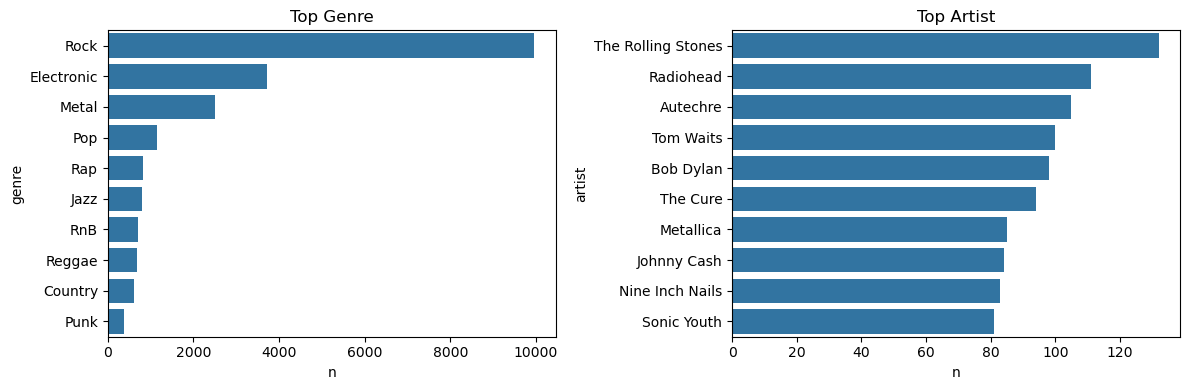

In [12]:
top_genre  = (music_df['genre']
              .value_counts()
              .head(10)
              .rename_axis('genre').reset_index(name='n'))
top_artist = (music_df['artist']
              .value_counts()
              .head(10)
              .rename_axis('artist').reset_index(name='n'))

fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.barplot(data=top_genre , x='n', y='genre' , ax=ax[0]); ax[0].set_title('Top Genre')
sns.barplot(data=top_artist, x='n', y='artist', ax=ax[1]); ax[1].set_title('Top Artist')
plt.tight_layout(); plt.show()

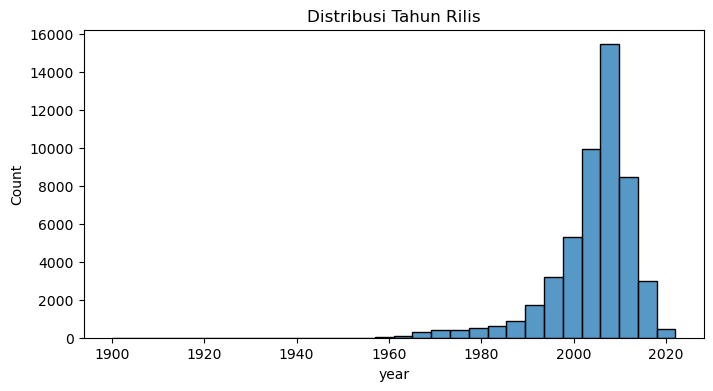

In [13]:
plt.figure(figsize=(8,4))
sns.histplot(music_df['year'].dropna(), bins=30)
plt.title('Distribusi Tahun Rilis'); plt.show()

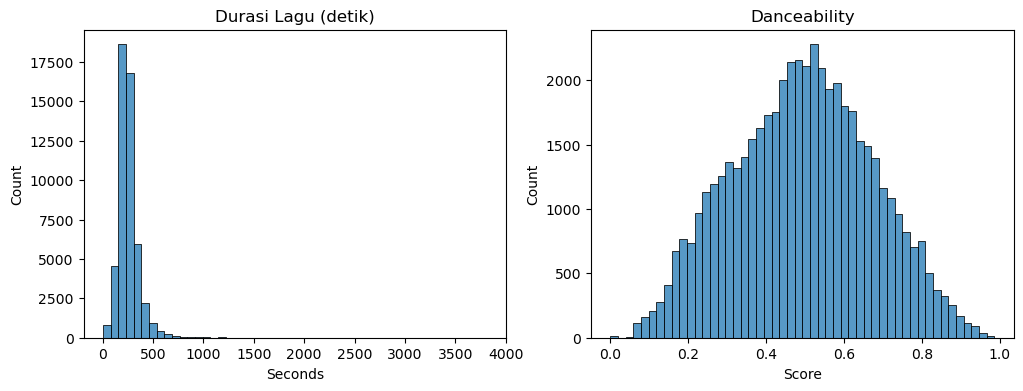

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(music_df['duration_ms']/1000, bins=50, ax=ax[0])
ax[0].set(title='Durasi Lagu (detik)', xlabel='Seconds')

sns.histplot(music_df['danceability'].dropna(), bins=50, ax=ax[1])
ax[1].set(title='Danceability', xlabel='Score')
plt.show()

In [15]:
print("--- Info Data User History Streaming ---")
user_listening_history_df.info()

--- Info Data User History Streaming ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9711301 entries, 0 to 9711300
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   track_id   object
 1   user_id    object
 2   playcount  int64 
dtypes: int64(1), object(2)
memory usage: 222.3+ MB


In [16]:
print("=== Unique User History Streaming Data ===")
print('Jumlah Track/Music : ', len(user_listening_history_df.track_id.unique()))
print('Jumlah User : ', len(user_listening_history_df.user_id.unique()))

=== Unique User History Streaming Data ===
Jumlah Track/Music :  30459
Jumlah User :  962037


In [17]:
print(user_listening_history_df.describe())

          playcount
count  9.711301e+06
mean   2.630946e+00
std    5.706324e+00
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    2.000000e+00
max    2.948000e+03


# **4. Data Preprocessing and Data Preparation**

In [19]:
print("=== Duplicate Check ===")
print(f"{'music_df'}: {music_df.duplicated().sum()} duplikat")
print(f"{'user_listening_history_df'}: {user_listening_history_df.duplicated().sum()} duplikat")

=== Duplicate Check ===
music_df: 0 duplikat
user_listening_history_df: 0 duplikat


In [20]:
print("======= Missing Values =======")
print("========== music_df ==========")
print(music_df.isna().sum())

======= Missing Values =======
========== music_df ==========
track_id                   0
name                       0
artist                     0
spotify_preview_url        0
spotify_id                 0
tags                    1127
genre                  28335
year                       0
duration_ms                0
danceability               0
energy                     0
key                        0
loudness                   0
mode                       0
speechiness                0
acousticness               0
instrumentalness           0
liveness                   0
valence                    0
tempo                      0
time_signature             0
dtype: int64


Karena data terlalu banyak maka akan didrop missing valuenya bukan diisi dengan 'unknown' dan bila data masih banyak setelah cleaning maka akan diambil 50.000 data saja untuk training

In [21]:
print("======= Missing Values =======")
print("= user_listening_history_df =")
print(user_listening_history_df.isna().sum())

======= Missing Values =======
= user_listening_history_df =
track_id     0
user_id      0
playcount    0
dtype: int64


In [22]:
# --- Drop lagu dgn genre NA ATAU tags NA Karena Data Terlalu Banyak -----------------
before_drop = music_df.shape[0]
music_clean = music_df.dropna(subset=['genre', 'tags'])
after_drop  = music_clean.shape[0]

print(f'Drop {before_drop-after_drop} lagu karena genre/tags kosong')
print('Music shape  :', music_clean.shape)

Drop 28767 lagu karena genre/tags kosong
Music shape  : (21916, 21)


In [23]:
# --- Sinkronkan riwayat ----------------------------------
valid_track_set = set(music_clean['track_id'])
history_sync = user_listening_history_df[user_listening_history_df['track_id'].isin(valid_track_set)]
print('History shape (sinkron):', history_sync.shape)

History shape (sinkron): (6280058, 3)


Hanya mengambil 50k data karena setelah drop null data music masih terlalu banyak

In [24]:
# --- Down-sample ±50k baris ------------------------------
TARGET_ROWS = 50_000
if history_sync.shape[0] > TARGET_ROWS:
    history_sample = history_sync.sample(n=TARGET_ROWS, random_state=42)
else:
    history_sample = history_sync.copy()
print('History shape (final)  :', history_sample.shape)

History shape (final)  : (50000, 3)


# **6. Pembangunan Model**

## **A. Content-Based Filtering (TF-IDF Cosine)**

In [41]:
music_clean.sample(5)

track_id                name                   artist  \
3693   TRUOCBA128E07822DF          A Reminder                Radiohead   
34912  TRFUXWR128F1486971   I Never Wanted To                   Saosin   
42235  TRFNAGR128F4277334   For Heaven's Sake               Lucy Swann   
44333  TRPSHKK128F4270EF0              Fatman  G. Love & Special Sauce   
9074   TRLKSOO128F428C5B5  Mississippi Goddam              Nina Simone   

                                     spotify_preview_url  \
3693   https://p.scdn.co/mp3-preview/798bb16c6d0b4baa...   
34912  https://p.scdn.co/mp3-preview/9bc99183ca4fb521...   
42235  https://p.scdn.co/mp3-preview/b26ecfa30cf5f6f8...   
44333  https://p.scdn.co/mp3-preview/8155a3538b9367ba...   
9074   https://p.scdn.co/mp3-preview/a792a352bb610c47...   

                   spotify_id  \
3693   0mDwIppo8rIodEVZQ9RBcR   
34912  1Jmh4yxfwub6PZBcjNibvM   
42235  2bwXH3RbhY046m0mgwqmWi   
44333  5llDMnlVGG4WdtxPnNj9An   
9074   03KtV4uBiQMPJoIoZbTYg6   

                                                    tags   genre  year  \
3693   rock, electronic, alternative, indie, alternat...    Rock  1997   
34912                        emo, post_hardcore, screamo    Rock  2008   
42235  electronic, pop, female_vocalists, singer_song...     Rap  2010   
44333                                         blues_rock  Reggae  1994   
9074                              jazz, soul, blues, 60s    Jazz  2005   

       duration_ms  danceability  ...  key  loudness  mode  speechiness  \
3693        233826         0.313  ...    9   -14.112     1       0.0283   
34912       210173         0.424  ...    0    -4.547     0       0.1170   
42235       233053         0.587  ...   10    -9.647     1       0.0297   
44333       253266         0.424  ...    9    -8.034     1       0.2820   
9074        332320         0.609  ...    4   -15.352     0       0.0510   

       acousticness  instrumentalness  liveness  valence    tempo  \
3693        0.31200          0.323000    0.2560    0.167   77.851   
34912       0.00063          0.000000    0.9380    0.230  134.995   
42235       0.19200          0.071300    0.0685    0.863  152.166   
44333       0.10900          0.000011    0.3260    0.115  170.699   
9074        0.42000          0.000000    0.9720    0.804  146.058   

       time_signature  
3693                3  
34912               4  
42235               4  
44333               4  
9074                4  

[5 rows x 21 columns]

In [27]:
tfidf = TfidfVectorizer()
tfidf.fit(music_clean['genre'])
tfidf.get_feature_names_out()

array(['age', 'blues', 'country', 'electronic', 'folk', 'jazz', 'latin',
       'metal', 'new', 'pop', 'punk', 'rap', 'reggae', 'rnb', 'rock',
       'world'], dtype=object)

In [28]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfidf.fit_transform(music_clean['genre']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(21916, 16)

In [29]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan nama genre
# Baris diisi dengan nama lagu
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tfidf.get_feature_names_out(),
    index=music_clean.name
).sample(16, axis=1).sample(10, axis=0)

electronic  country  world  rnb  rock  blues  \
name                                                                        
Let's Kiss and Make Up              0.0      0.0    0.0  0.0   1.0    0.0   
Another Girl Another Planet         0.0      0.0    0.0  0.0   1.0    0.0   
Rules and Regulations               0.0      0.0    0.0  0.0   1.0    0.0   
Combustion                          0.0      0.0    0.0  0.0   1.0    0.0   
Carry                               0.0      0.0    0.0  0.0   0.0    0.0   
Pyramid                             0.0      0.0    0.0  0.0   0.0    0.0   
Gravedancer                         0.0      0.0    0.0  0.0   0.0    0.0   
Signals Over The Air                0.0      0.0    0.0  0.0   1.0    0.0   
From the Ritz to the Rubble         0.0      0.0    0.0  0.0   1.0    0.0   
Preaching the Blues                 0.0      0.0    0.0  0.0   1.0    0.0   

                             jazz  punk  metal  pop  latin  new  reggae  rap  \
name                                                                           
Let's Kiss and Make Up        0.0   0.0    0.0  0.0    0.0  0.0     0.0  0.0   
Another Girl Another Planet   0.0   0.0    0.0  0.0    0.0  0.0     0.0  0.0   
Rules and Regulations         0.0   0.0    0.0  0.0    0.0  0.0     0.0  0.0   
Combustion                    0.0   0.0    0.0  0.0    0.0  0.0     0.0  0.0   
Carry                         0.0   0.0    1.0  0.0    0.0  0.0     0.0  0.0   
Pyramid                       1.0   0.0    0.0  0.0    0.0  0.0     0.0  0.0   
Gravedancer                   0.0   0.0    1.0  0.0    0.0  0.0     0.0  0.0   
Signals Over The Air          0.0   0.0    0.0  0.0    0.0  0.0     0.0  0.0   
From the Ritz to the Rubble   0.0   0.0    0.0  0.0    0.0  0.0     0.0  0.0   
Preaching the Blues           0.0   0.0    0.0  0.0    0.0  0.0     0.0  0.0   

                             folk  age  
name                                    
Let's Kiss and Make Up        0.0  0.0  
Another Girl Another Planet   0.0  0.0  
Rules and Regulations         0.0  0.0  
Combustion                    0.0  0.0  
Carry                         0.0  0.0  
Pyramid                       0.0  0.0  
Gravedancer                   0.0  0.0  
Signals Over The Air          0.0  0.0  
From the Ritz to the Rubble   0.0  0.0  
Preaching the Blues           0.0  0.0

In [31]:
# Cosine
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [32]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama musik
cosine_sim_df = pd.DataFrame(cosine_sim, index=music_clean['name'], columns=music_clean['name'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (21916, 21916)


name                                   One Brick  Mujer Amante  \
name                                                             
District Line II                             0.0           0.0   
Dungeness                                    0.0           0.0   
Patterns in the Ivy                          0.0           1.0   
68 Balcony                                   0.0           0.0   
Might                                        0.0           0.0   
I Can Do It Without You                      0.0           0.0   
Crepuscule With Nellie                       0.0           0.0   
You and Me and One Spotlight                 0.0           0.0   
The Girl Next Door                           0.0           0.0   
Hedonism (Just Because You Feel Good)        0.0           0.0   

name                                   Flower in the Sun  Oriental Melody  \
name                                                                        
District Line II                                     0.0              0.0   
Dungeness                                            0.0              0.0   
Patterns in the Ivy                                  0.0              0.0   
68 Balcony                                           0.0              0.0   
Might                                                1.0              1.0   
I Can Do It Without You                              1.0              1.0   
Crepuscule With Nellie                               0.0              0.0   
You and Me and One Spotlight                         1.0              1.0   
The Girl Next Door                                   1.0              1.0   
Hedonism (Just Because You Feel Good)                1.0              1.0   

name                                   Trip Hoppin'  
name                                                 
District Line II                                0.0  
Dungeness                                       0.0  
Patterns in the Ivy                             0.0  
68 Balcony                                      0.0  
Might                                           1.0  
I Can Do It Without You                         1.0  
Crepuscule With Nellie                          0.0  
You and Me and One Spotlight                    1.0  
The Girl Next Door                              1.0  
Hedonism (Just Because You Feel Good)           1.0

In [ ]:
def music_recommendations(name, similarity_data=cosine_sim_df, items=music_clean[['name', 'genre']], k=5):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,name].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    closest = closest.drop(name, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [85]:
music_clean[music_clean.artist.eq('The Weeknd')]

track_id                 name      artist  \
3038   TRREYQA128F4279D4B         In The Night  The Weeknd   
3524   TRXDMYV128F92FF488          Coming Down  The Weeknd   
14551  TREHUVX128F42638E9          Die For You  The Weeknd   
32870  TRMJPWB128F424DD33  Nothing Without You  The Weeknd   

                                     spotify_preview_url  \
3038   https://p.scdn.co/mp3-preview/fa8aeb7f26f53fe6...   
3524   https://p.scdn.co/mp3-preview/76f7fd4c0b5ad259...   
14551  https://p.scdn.co/mp3-preview/e49424092c7cdea0...   
32870  https://p.scdn.co/mp3-preview/c5e1db9407faef4b...   

                   spotify_id  \
3038   17ghHlAfjnAIEpYGTlX4GL   
3524   3PsS445MHcmtroGTstfTbm   
14551  1zF69Xru3AToRB87kAKqra   
32870  3Te3gG6MPEDNqLGzWrjKC3   

                                                    tags       genre  year  \
3038               electronic, pop, dance, rnb, synthpop         Pop  2016   
3524   electronic, experimental, soul, trip_hop, indi...  Electronic  2012   
14551                                 soul, hip_hop, rnb        Rock  2016   
32870                                           pop, rnb        Rock  2016   

       duration_ms  danceability  ...  key  loudness  mode  speechiness  \
3038        235626         0.400  ...    7    -4.967     1       0.1250   
3524        295453         0.665  ...    2    -4.664     0       0.0314   
14551       260253         0.587  ...    1    -7.182     0       0.0763   
32870       198653         0.599  ...    1    -8.101     1       0.0679   

       acousticness  instrumentalness  liveness  valence    tempo  \
3038         0.0803          0.000000    0.0484    0.508  112.122   
3524         0.4870          0.000194    0.1830    0.250  120.989   
14551        0.1050          0.000000    0.1470    0.486  133.881   
32870        0.0640          0.000000    0.0878    0.194  109.919   

       time_signature  
3038                4  
3524                4  
14551               4  
32870               4  

[4 rows x 21 columns]

In [65]:
music_clean[music_clean.name.eq('Die For You')]

track_id         name      artist  \
14551  TREHUVX128F42638E9  Die For You  The Weeknd   

                                     spotify_preview_url  \
14551  https://p.scdn.co/mp3-preview/e49424092c7cdea0...   

                   spotify_id                tags genre  year  duration_ms  \
14551  1zF69Xru3AToRB87kAKqra  soul, hip_hop, rnb  Rock  2016       260253   

       danceability  ...  key  loudness  mode  speechiness  acousticness  \
14551         0.587  ...    1    -7.182     0       0.0763         0.105   

       instrumentalness  liveness  valence    tempo  time_signature  
14551               0.0     0.147    0.486  133.881               4  

[1 rows x 21 columns]

In [66]:
music_recommendations('Die For You')

name genre
0                   Winding road  Rock
1              Mogwai Fear Satan  Rock
2           The World Is Our ___  Rock
3                        Atrophy  Rock
4  I Know You Are But What Am I?  Rock

## **B. Collaborative-Based Filtering (RecommenderNet)**

In [94]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids  = history_sample['user_id'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded  = {x:i for i,x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user  = {i:x for i,x in enumerate(user_ids)}
print('encoded userID : ', user_encoded_to_user)

list userID:  ['531ae07c9d82ecee2886f344996182e222a218d4', '5207fc964883a6e63f93ab95af3369961765f548', 'baccd1ab9864968142f28c0ca9578d0bfca8da70', '34f147bb3751cac46eef5b0b4bf06a946d970335', '41ec147314aed40b419d7a077a4abf1b375bab57', 'f99a25251dfd3c44b629c3658bf6c0d0a7a3d0ce', '5c133af017c22ee1337904f2805d9f171f431fbe', '456b6f555665f325660543c854857f9544cae441', '51350597e0f6d3aacb8a8edba3d80faaf1dd5954', '062eca5902db925937c295961bf2ea9c86e0eac7', '2f6569911812b0e2f75da4e7880ef0e58303d080', '6d2ac0975359b3c584ffe1e8f24c61b7ba049c0c', '9c473068f547b81aa5828c174806bac40c072cb2', '2272d4540fe93eb12280b14bdfd748020988495d', '1beca80baa936cc786d5c579442e4e8d78576500', 'd61ed50930b25f1dd54a04c739398f338dace5cc', '207f604c6a749b31c976e5571acb3902633586d5', '9fa77428d5358dab3e33c7645f3b7aca0a45e927', '1f1329e2a26e5b18f92ce32d0f6122b4af8498ad', '544234d5f4b3bb65781cfa863f46f8b64f8338db', 'ec43698e80e6408ce940ae84d198530933281268', '5aaa5a09f824f16808fe661f7064be220000d3eb', '150a2742303e4046

In [95]:
# Mengubah trackID menjadi list tanpa nilai yang sama
track_ids = music_clean['track_id'].unique().tolist()
print('list trackID: ', track_ids)

# Melakukan encoding trackID
track_to_track_encoded = {x:i for i,x in enumerate(track_ids)}
print('encoded trackID : ', track_to_track_encoded)

# Melakukan proses encoding angka ke ke trackID
track_encoded_to_track = {i:x for i,x in enumerate(track_ids)}
print('encoded trackID : ', track_encoded_to_track)

list trackID:  ['TROUVHL128F426C441', 'TRLNZBD128F935E4D8', 'TRMZXEW128F9341FD5', 'TRIODZU128E078F3E2', 'TRYEZGE128F92D04C8', 'TRUENYK128F4274057', 'TRWEHTV12903D086FC', 'TRIQWYH128F1486062', 'TRUOEWJ128F9345A85', 'TRAOMFT128F42A7684', 'TRNNGMK128F423F034', 'TRVRWFY128F4286EF9', 'TRADPIA128E078EE1B', 'TRIMWJA128F9309A68', 'TRRISDV128F42A72DA', 'TRSFPEE128F429B0EE', 'TRPFYYL128F92F7144', 'TRLPNCR128F4262D8E', 'TRFROHP128F9309571', 'TRUGANP12903CB2C46', 'TRFNTRW128F422C28C', 'TRFWGOJ128E0780C8B', 'TRHMVGF128E078ED9B', 'TRSCMBY128F9311188', 'TRYFDIV128F42BAF81', 'TRCSKKO128EF33DD14', 'TRYJPIH128F4262602', 'TRAAHSY128F147BB5C', 'TRPSVTL128F936017F', 'TRXNSKZ128F427F1FB', 'TRASRXK128F9311176', 'TRRVVTK128F422BB5D', 'TROCLWN128F92EB284', 'TRWQINA128F9339E57', 'TRRKQMW128F9312597', 'TRFOVTO128F4228CC3', 'TRINBYX128E0788920', 'TRXCCHH128F429C0A9', 'TRYFESD128F424095C', 'TRRGJNU128F92F42BF', 'TRCBZKH128F4277109', 'TRXIBFG128F42A4CFF', 'TRBRRRZ128F930AB47', 'TRGDQFS128F933AD5C', 'TRRIGXH12903CB1

In [96]:
# kolom indeks numerik & label
history_sample['user_idx']  = history_sample['user_id'] \
                                .map(user_to_user_encoded)
history_sample['track_idx'] = history_sample['track_id'] \
                                .map(track_to_track_encoded)

# label 0‒1 dari playcount
pc_min, pc_max = history_sample['playcount'].min(), \
                 history_sample['playcount'].max()
history_sample['rating'] = (history_sample['playcount'] - pc_min) / (pc_max - pc_min)
history_sample['rating'] = history_sample['rating'].astype(np.float32)

In [97]:
# ---------------------------------------------------------------------
# Shuffle & split (80 % train - 20 % valid)                        |
# ---------------------------------------------------------------------
history_sample = history_sample.sample(frac=1, random_state=42)  # acak
split_at = int(0.8 * len(history_sample))
train_df = history_sample.iloc[:split_at]
val_df   = history_sample.iloc[split_at:]

x_train = train_df[['user_idx', 'track_idx']].values
y_train = train_df['rating'].values
x_val   = val_df[['user_idx', 'track_idx']].values
y_val   = val_df['rating'].values

print(f"Train: {len(x_train)} | Val: {len(x_val)}")

Train: 40000 | Val: 10000


In [98]:
n_users  = len(user_to_user_encoded)
n_items  = len(track_to_track_encoded)
EMB_DIM  = 50 

class RecommenderNet(tf.keras.Model):
    def __init__(self, n_user, n_item, emb_dim=50, **kw):
        super().__init__(**kw)
        self.user_emb  = layers.Embedding(
            n_user, emb_dim,
            embeddings_initializer='he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6))
        self.item_emb  = layers.Embedding(
            n_item, emb_dim,
            embeddings_initializer='he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(n_user, 1)
        self.item_bias = layers.Embedding(n_item, 1)

    def call(self, inputs):
        u   = self.user_emb (inputs[:, 0])
        i   = self.item_emb (inputs[:, 1])
        ub  = self.user_bias(inputs[:, 0])
        ib  = self.item_bias(inputs[:, 1])
        x   = tf.reduce_sum(u * i, axis=1, keepdims=True) + ub + ib
        return tf.nn.sigmoid(x)          # output 0‒1

model_nm = RecommenderNet(n_users, n_items, EMB_DIM)
model_nm.compile(
    optimizer = keras.optimizers.Adam(0.001),
    loss      = keras.losses.BinaryCrossentropy(),
    metrics   = [keras.metrics.RootMeanSquaredError()]
)

history_nm = model_nm.fit(
    x_train, y_train,
    batch_size     = 512,
    epochs         = 30,
    validation_data= (x_val, y_val),
    verbose        = 2
)

Epoch 1/30
79/79 - 5s - 66ms/step - loss: 0.6861 - root_mean_squared_error: 0.4903 - val_loss: 0.6776 - val_root_mean_squared_error: 0.4858
Epoch 2/30
79/79 - 4s - 50ms/step - loss: 0.6640 - root_mean_squared_error: 0.4789 - val_loss: 0.6619 - val_root_mean_squared_error: 0.4775
Epoch 3/30
79/79 - 4s - 48ms/step - loss: 0.6361 - root_mean_squared_error: 0.4639 - val_loss: 0.6478 - val_root_mean_squared_error: 0.4697
Epoch 4/30
79/79 - 4s - 45ms/step - loss: 0.5944 - root_mean_squared_error: 0.4406 - val_loss: 0.6359 - val_root_mean_squared_error: 0.4624
Epoch 5/30
79/79 - 5s - 59ms/step - loss: 0.5380 - root_mean_squared_error: 0.4077 - val_loss: 0.6267 - val_root_mean_squared_error: 0.4559
Epoch 6/30
79/79 - 4s - 54ms/step - loss: 0.4743 - root_mean_squared_error: 0.3684 - val_loss: 0.6202 - val_root_mean_squared_error: 0.4502
Epoch 7/30
79/79 - 4s - 53ms/step - loss: 0.4122 - root_mean_squared_error: 0.3276 - val_loss: 0.6159 - val_root_mean_squared_error: 0.4454
Epoch 8/30
79/79 - 4

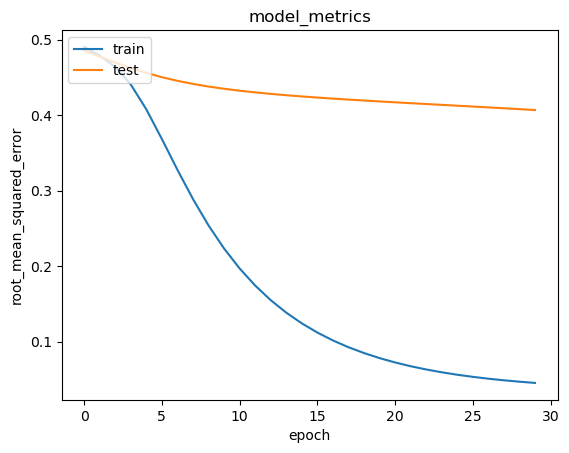

In [101]:
plt.plot(history_nm.history['root_mean_squared_error'])
plt.plot(history_nm.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [102]:
# ---------------------------------------------------------------------
# Fungsi Rekomendasi                       
# ---------------------------------------------------------------------
# helper untuk memetakan index→id
idx2user  = {i:u for u,i in user_to_user_encoded.items()}
idx2track = {i:t for t,i in track_to_track_encoded.items()}

def rec_cf_nm(user_id, k=10):
    """Top-k rekomendasi lagu untuk satu user berbasis model neural."""
    uid = user_to_user_encoded[user_id]
    # skor ke seluruh item
    item_idx = np.arange(n_items)
    inp  = np.stack([np.full(n_items, uid), item_idx], axis=1)
    preds = model_nm.predict(inp, batch_size=4096, verbose=0).ravel()

    # abaikan lagu yang sudah pernah diputar
    heard = set(history_sample[history_sample['user_id']==user_id]['track_id'])
    mask  = np.array([idx2track[i] not in heard for i in item_idx])
    top   = preds[mask].argsort()[-k:][::-1]
    chosen_idx = item_idx[mask][top]
    return music_clean.iloc[chosen_idx][['track_id','name','artist']]

In [ ]:
# ---------------------------------------------------------------------
# Inferensi Contoh                                                 |
# ---------------------------------------------------------------------
sample_user = history_sample.iloc[0]['user_id']
print(f"Rekomendasi 5 lagu untuk user {sample_user}")
display(rec_cf_nm(sample_user, k=5))


Rekomendasi 5 lagu untuk user 7a7cc88945e473bf60cd32d6f286e845982227f5


track_id                    name               artist
59     TRPFYYL128F92F7144                Float On         Modest Mouse
5231   TRABFDT12903CADD73            Up Up & Away             Kid Cudi
22071  TRPGPDK12903CCC651        Bring Me To Life    Katherine Jenkins
153    TRWVOJJ12903CCC654             My Immortal          Evanescence
14148  TRIRQPO128F4281996  We Are the Sleepyheads  Belle and Sebastian

batas

In [ ]:
!pip freeze requirements.txt

absl-py==2.2.2
aext-assistant @ file:///C:/b/abs_98xvdek9qa/croot/aext-assistant_1734644152369/work
aext-assistant-server @ file:///C:/b/abs_93twy7n40b/croot/aext-assistant-server_1734640405857/work
aext-core @ file:///C:/b/abs_73k82brgp5/croot/aext-core_1734637800697/work
aext-core-server @ file:///C:/b/abs_e3xgm257mx/croot/aext-core-server_1734635079146/work
aext-panels @ file:///C:/b/abs_e40tdjfcpq/croot/aext-panels_1734643464834/work
aext-panels-server @ file:///C:/b/abs_546lo5c36i/croot/aext-panels-server_1734640142498/work
aext-project-filebrowser-server @ file:///C:/b/abs_11ixe7hbzm/croot/aext-project-filebrowser-server_1734687629540/work/backend_lib/project_filebrowser
aext-share-notebook @ file:///C:/b/abs_fewa44_d8o/croot/aext-share-notebook_1734642886563/work
aext-share-notebook-server @ file:///C:/b/abs_3dkdp713ad/croot/aext-share-notebook-server_1734639662890/work
aext-shared @ file:///C:/b/abs_6bq_wjfbhn/croot/aext-shared_1734628822229/work
aext-toolbox @ file:///C:/b/abs